<a href="https://colab.research.google.com/github/brandiegriffin83/ITAI3377_L04_GROUP/blob/main/L05_BrandyGriffin_ITAI4374.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 05 — Sensory Processing & AI Perception
## ITAI 4374: Neuroscience as a Model for AI

---

**Module 05** taught us how the brain transforms raw physical energy — light, sound, pressure — into the rich perceptual world we experience. In this lab, you will *become* the sensory system: applying the same computational principles the brain uses, then comparing them to what artificial neural networks learn on their own.

---

### 🛤️ Two Tracks — Read This First

This lab has **two tracks** depending on your computing resources:

| Badge | Meaning | Who |
|-------|---------|-----|
| 🟢 **ALL STUDENTS** | Core exercises — **everyone completes these** | All students |
| 🔵 **GPU TRACK** | Optional enrichment — requires a GPU runtime | Students with GPU access (e.g., Colab GPU) |

**If you do NOT have GPU access:**
- Complete all 🟢 cells
- **Skip** all 🔵 cells — pre-computed results are provided so you can still answer reflection questions
- You will NOT lose points for skipping 🔵 cells

**If you DO have GPU access:**
- Complete all 🟢 cells AND all 🔵 cells
- 🔵 cells give you hands-on experience training small models
- To enable GPU in Colab: `Runtime → Change runtime type → T4 GPU`

---

### Lab Structure

| Part | Title | Track | Estimated Time |
|------|-------|-------|----------------|
| A | "Be the Retina" — Biological Image Filtering | 🟢 All | 30–40 min |
| B | "Inside a CNN" — Comparing Bio vs. Artificial Features | 🟢 + 🔵 | 30–40 min |
| C | "Hearing in Pictures" — Auditory Processing | 🟢 + 🔵 | 25–35 min |
| D | Experiments | 🟢 All | 20–30 min |
| E | Reflections | 🟢 All | 15–20 min |

**Total estimated time:** 2–2.5 hours

---

### What to Submit

1. This completed notebook (`.ipynb`) with all code cells executed and all text responses filled in
2. Name your file: `L05_YourName_ITAI4374.ipynb`
3. Upload to the Canvas assignment

---

## 🟢 Setup — Run This First

Run the cell below to install and import everything you need. This works on **CPU only** — no GPU required.

In [20]:
# ============================================================
# SETUP — Run this cell first (CPU only, no GPU needed)
# ============================================================
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy import signal, ndimage
from PIL import Image
import io, os, warnings
warnings.filterwarnings('ignore')

# Check if GPU is available (for track selection)
try:
    import torch
    import torchvision
    GPU_AVAILABLE = torch.cuda.is_available()
    DEVICE = 'cuda' if GPU_AVAILABLE else 'cpu'
    print(f"PyTorch version: {torch.__version__}")
    print(f"GPU available: {GPU_AVAILABLE}")
    if GPU_AVAILABLE:
        print(f"GPU name: {torch.cuda.get_device_name(0)}")
        print("✅ You can complete both 🟢 and 🔵 track exercises!")
    else:
        print("ℹ️ No GPU detected — complete all 🟢 exercises. Skip 🔵 cells.")
except ImportError:
    GPU_AVAILABLE = False
    DEVICE = 'cpu'
    print("ℹ️ PyTorch not available — complete all 🟢 exercises. Skip 🔵 cells.")

# Plotting defaults
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['font.size'] = 11

print("\n✅ Setup complete!")

PyTorch version: 2.10.0+cpu
GPU available: False
ℹ️ No GPU detected — complete all 🟢 exercises. Skip 🔵 cells.

✅ Setup complete!


## 🟢 Generate Sample Images

Instead of downloading large datasets, we will **create** our test images programmatically. This keeps the lab lightweight and ensures it runs on any machine.

Run the cell below — it creates three test images that mimic what the visual system encounters.

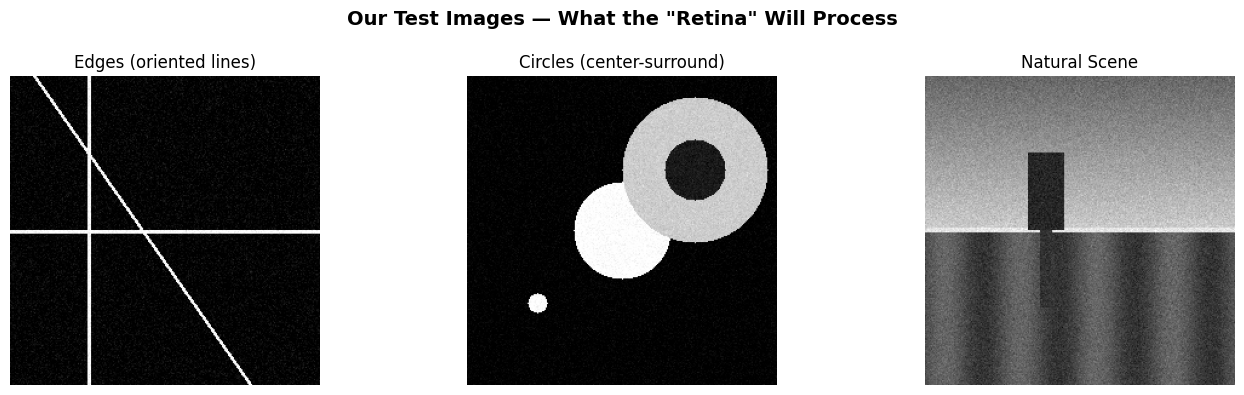

✅ Three test images generated (256×256 pixels each, no files downloaded)


In [21]:
# ============================================================
# Generate test images (no downloads needed)
# ============================================================
np.random.seed(42)

def make_edges_image(size=256):
    """Image with clear edges at different orientations."""
    img = np.zeros((size, size), dtype=np.float64)
    # Vertical edge
    img[:, size//4:size//4+3] = 1.0
    # Horizontal edge
    img[size//2:size//2+3, :] = 1.0
    # Diagonal edge
    for i in range(size):
        j = int(i * 0.7) + 20
        if 0 <= j < size:
            img[i, max(0,j-1):min(size,j+2)] = 1.0
    # Add some noise (realistic — retinal signals are noisy)
    img += np.random.normal(0, 0.05, img.shape)
    return np.clip(img, 0, 1)

def make_circles_image(size=256):
    """Image with circular features — tests center-surround responses."""
    img = np.zeros((size, size), dtype=np.float64)
    y, x = np.ogrid[-size//2:size//2, -size//2:size//2]
    # Bright circle on dark background
    mask1 = x**2 + y**2 <= 40**2
    img[mask1] = 1.0
    # Dark circle on bright patch
    bright_patch = (x-60)**2 + (y+50)**2 <= 60**2
    dark_circle = (x-60)**2 + (y+50)**2 <= 25**2
    img[bright_patch] = 0.8
    img[dark_circle] = 0.1
    # Small dot (tests fine resolution)
    dot = (x+70)**2 + (y-60)**2 <= 8**2
    img[dot] = 1.0
    img += np.random.normal(0, 0.03, img.shape)
    return np.clip(img, 0, 1)

def make_natural_scene(size=256):
    """Synthetic 'natural' scene with textures and gradients."""
    img = np.zeros((size, size), dtype=np.float64)
    # Sky gradient (top)
    for i in range(size//2):
        img[i, :] = 0.4 + 0.4 * (i / (size//2))
    # Ground texture (bottom)
    for i in range(size//2, size):
        img[i, :] = 0.3 + 0.1 * np.sin(np.arange(size) * 0.1)
    # Horizon line
    img[size//2-2:size//2+2, :] = 0.9
    # "Tree" rectangle
    img[size//4:size//2, size//3:size//3+30] = 0.15
    img[size//2:3*size//4, size//3+10:size//3+20] = 0.2
    img += np.random.normal(0, 0.04, img.shape)
    return np.clip(img, 0, 1)

# Generate the three images
img_edges = make_edges_image()
img_circles = make_circles_image()
img_scene = make_natural_scene()

# Display them
fig, axes = plt.subplots(1, 3, figsize=(14, 4))
titles = ['Edges (oriented lines)', 'Circles (center-surround)', 'Natural Scene']
for ax, img, title in zip(axes, [img_edges, img_circles, img_scene], titles):
    ax.imshow(img, cmap='gray', vmin=0, vmax=1)
    ax.set_title(title, fontsize=12)
    ax.axis('off')
plt.suptitle('Our Test Images — What the "Retina" Will Process', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("✅ Three test images generated (256×256 pixels each, no files downloaded)")

---

# Part A: "Be the Retina" — Biological Image Filtering

## 🟢 ALL STUDENTS

In Module 05 you learned that the retina is not a passive camera — it already **computes**. Retinal ganglion cells have **center-surround receptive fields** that detect local contrast, not absolute brightness. This is the very first stage of visual processing.

In this part, you will implement these biological operations as image filters and observe what the retina "sees."

---

### A.1 Center-Surround Receptive Fields (Retinal Ganglion Cells)

A retinal ganglion cell responds to a small patch of the visual field called its **receptive field**. An ON-center cell fires when the center of its receptive field is bright and the surround is dark. An OFF-center cell does the opposite.

Mathematically, this is modeled as a **Difference of Gaussians (DoG)** — a narrow Gaussian (the center) minus a wider Gaussian (the surround).

**TODO 1:** Complete the function below to create a center-surround filter.

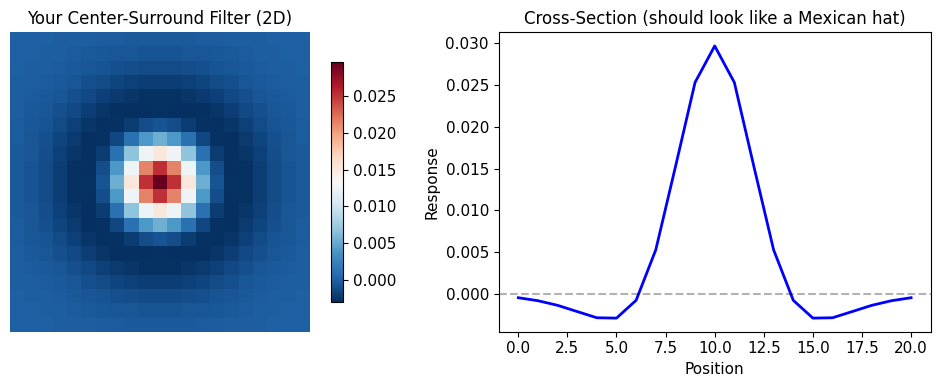

✅ Checkpoint passed! Positive center, negative surround — just like a real ganglion cell.


In [22]:
# ============================================================
# TODO 1: Create a center-surround (Difference of Gaussians) filter
# ============================================================

def make_center_surround(size=21, sigma_center=2.0, sigma_surround=4.0):
    ax = np.arange(-size // 2 + 1, size // 2 + 1)
    x, y = np.meshgrid(ax, ax)

    center = np.exp(-(x**2 + y**2) / (2 * sigma_center**2))
    surround = np.exp(-(x**2 + y**2) / (2 * sigma_surround**2))

    # normalize for stability
    center = center / center.sum()
    surround = surround / surround.sum()

    dog = center - surround
    return dog


# Test your filter
dog_filter = make_center_surround()

# Checkpoint: If correct, you should see a bright center and dark surround
if dog_filter is not None:
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    im = axes[0].imshow(dog_filter, cmap='RdBu_r')
    axes[0].set_title('Your Center-Surround Filter (2D)', fontsize=12)
    axes[0].axis('off')
    plt.colorbar(im, ax=axes[0], shrink=0.8)

    mid = dog_filter.shape[0] // 2
    axes[1].plot(dog_filter[mid, :], 'b-', linewidth=2)
    axes[1].axhline(y=0, color='k', linestyle='--', alpha=0.3)
    axes[1].set_title('Cross-Section (should look like a Mexican hat)', fontsize=12)
    axes[1].set_xlabel('Position')
    axes[1].set_ylabel('Response')
    plt.tight_layout()
    plt.show()

    if dog_filter[mid, mid] > 0 and dog_filter[mid, 0] < 0:
        print("✅ Checkpoint passed! Positive center, negative surround — just like a real ganglion cell.")
    else:
        print("⚠️ Check your filter — center should be positive, surround should be negative.")
else:
    print("❌ Filter is None — fill in the YOUR CODE HERE section above.")

### A.2 Apply the Center-Surround to Our Images

Now let's see what the retina "sees" when it processes our test images through center-surround receptive fields.

**TODO 2:** Apply your DoG filter to all three test images using `scipy.ndimage.convolve`.

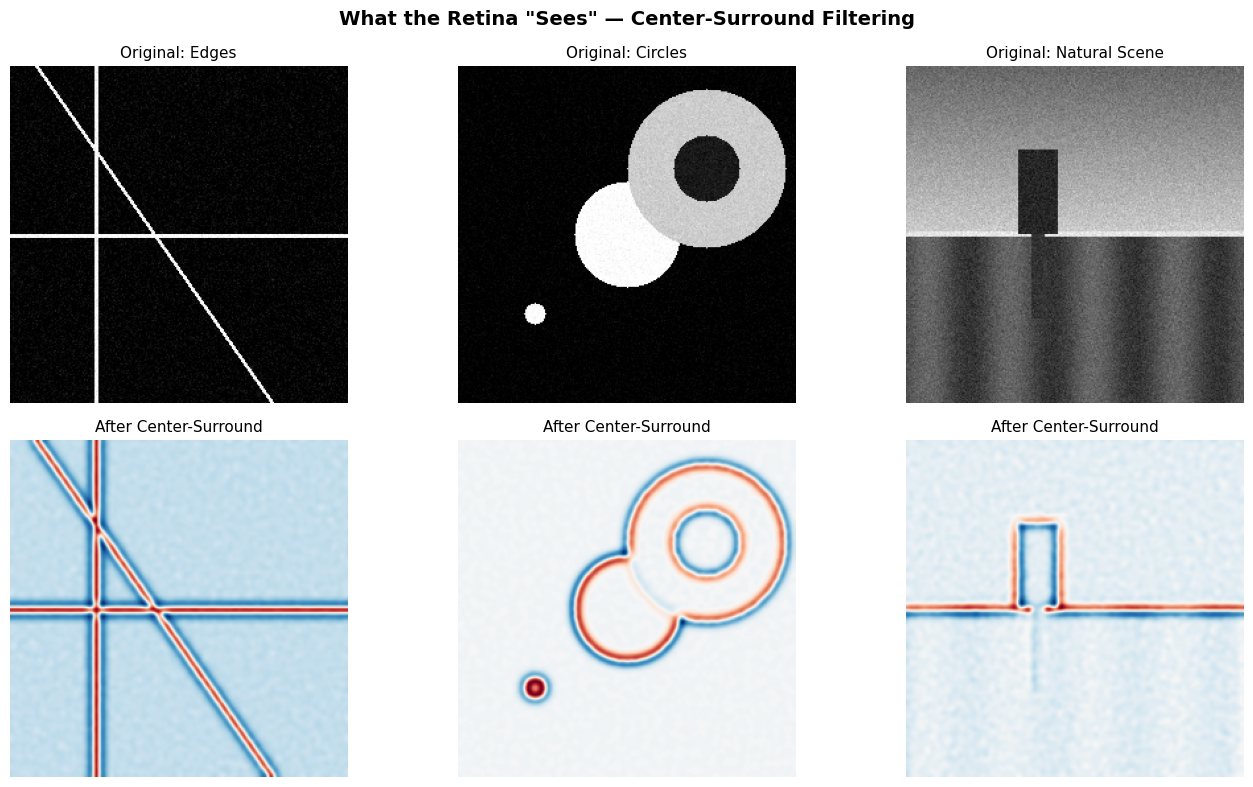

✅ Notice how uniform regions become flat (near zero) — the retina ignores constant brightness!
   It only responds to CHANGES and EDGES. This is lateral inhibition in action.


In [23]:
# ============================================================
# TODO 2: Apply center-surround filter to all three images
# ============================================================

edges_filtered = ndimage.convolve(img_edges, dog_filter)
circles_filtered = ndimage.convolve(img_circles, dog_filter)
scene_filtered = ndimage.convolve(img_scene, dog_filter)

if edges_filtered is not None:
    fig, axes = plt.subplots(2, 3, figsize=(14, 8))
    originals = [img_edges, img_circles, img_scene]
    filtered = [edges_filtered, circles_filtered, scene_filtered]
    titles = ['Edges', 'Circles', 'Natural Scene']

    for i in range(3):
        axes[0, i].imshow(originals[i], cmap='gray', vmin=0, vmax=1)
        axes[0, i].set_title(f'Original: {titles[i]}', fontsize=11)
        axes[0, i].axis('off')

        axes[1, i].imshow(filtered[i], cmap='RdBu_r')
        axes[1, i].set_title(f'After Center-Surround', fontsize=11)
        axes[1, i].axis('off')

    plt.suptitle('What the Retina "Sees" — Center-Surround Filtering', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

    print("✅ Notice how uniform regions become flat (near zero) — the retina ignores constant brightness!")
    print("   It only responds to CHANGES and EDGES. This is lateral inhibition in action.")
else:
    print("❌ Fill in TODO 2 above.")

### ❓ Knowledge Check 1

Answer in the cell below:

**Q1.1:** Look at the center-surround filtered images above. Why do uniform (constant brightness) regions appear as near-zero (flat gray) after filtering? What biological principle does this demonstrate?

Uniform regions show up as near zero after filtering because nothing is really changing in those areas. The center and the surround are seeing the same brightness, so when one is subtracted from the other, they basically cancel out. That’s why it looks flat and gray. This demonstrates lateral inhibition, which is how the retina focuses more on contrast and differences rather than constant light. Our visual system is built to notice changes, especially edges, not smooth surfaces that stay the same.*


**Q1.2:** In the circles image, which features produce the STRONGEST response after center-surround filtering — the edges of the circles or the interiors? Why does this make biological sense?

The strongest responses come from the edges of the circles, not the interiors. That’s because edges create a sudden shift from dark to light, which makes the center and surround respond differently. Inside the circles, the brightness is mostly consistent, so the responses cancel out again. Biologically, this makes sense because our eyes are designed to detect boundaries and shapes. Edges help us identify objects, while flat areas don’t give us much useful information.*



---

### A.3 Gabor Filters — Mimicking V1 Simple Cells

After the retina, visual signals travel to the primary visual cortex (V1). Hubel and Wiesel discovered that V1 neurons respond to **oriented edges** — a vertical bar, a horizontal bar, a diagonal bar. Each neuron is tuned to a specific orientation.

A **Gabor filter** is the mathematical equivalent: a wave pattern wrapped in a soft-edged window. By changing the angle of the sinusoid, we can create filters tuned to any orientation — just like V1 simple cells.

**TODO 3:** Create a bank of Gabor filters at 4 different orientations (0°, 45°, 90°, 135°).

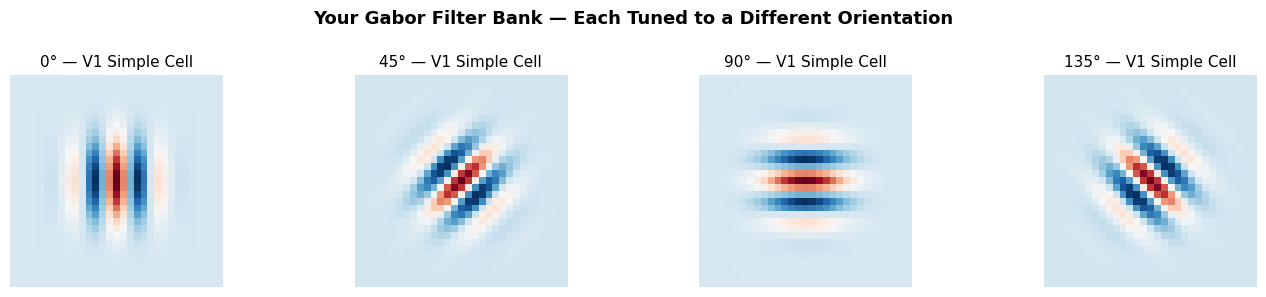

✅ You just built a miniature V1! Each filter is a simulated simple cell.


In [24]:
# ============================================================
# TODO 3: Create a bank of Gabor filters at different orientations
# ============================================================

def make_gabor(size=31, sigma=4.0, theta=0, frequency=0.15):
    ax = np.arange(-size // 2 + 1, size // 2 + 1)
    x, y = np.meshgrid(ax, ax)

    x_rot = x * np.cos(theta) + y * np.sin(theta)
    y_rot = -x * np.sin(theta) + y * np.cos(theta)

    gaussian = np.exp(-(x_rot**2 + y_rot**2) / (2 * sigma**2))
    sinusoid = np.cos(2 * np.pi * frequency * x_rot)

    gabor = gaussian * sinusoid
    gabor = gabor - gabor.mean()   # optional zero-mean
    return gabor


orientations_deg = [0, 45, 90, 135]
orientations_rad = [np.deg2rad(d) for d in orientations_deg]

gabor_bank = []
for theta in orientations_rad:
    g = make_gabor(theta=theta)
    gabor_bank.append(g)

if len(gabor_bank) == 4 and gabor_bank[0] is not None:
    fig, axes = plt.subplots(1, 4, figsize=(14, 3))
    for i, (g, deg) in enumerate(zip(gabor_bank, orientations_deg)):
        axes[i].imshow(g, cmap='RdBu_r')
        axes[i].set_title(f'{deg}° — V1 Simple Cell', fontsize=11)
        axes[i].axis('off')
    plt.suptitle('Your Gabor Filter Bank — Each Tuned to a Different Orientation', fontsize=13, fontweight='bold')
    plt.tight_layout()
    plt.show()
    print("✅ You just built a miniature V1! Each filter is a simulated simple cell.")
else:
    print("❌ Fill in the make_gabor function above.")

### A.4 Apply the Gabor Bank to Our Images

Now let's see how V1 responds to our test images. Each filter will highlight edges at its preferred orientation.

**TODO 4:** Apply each Gabor filter to the edges image and display the results.

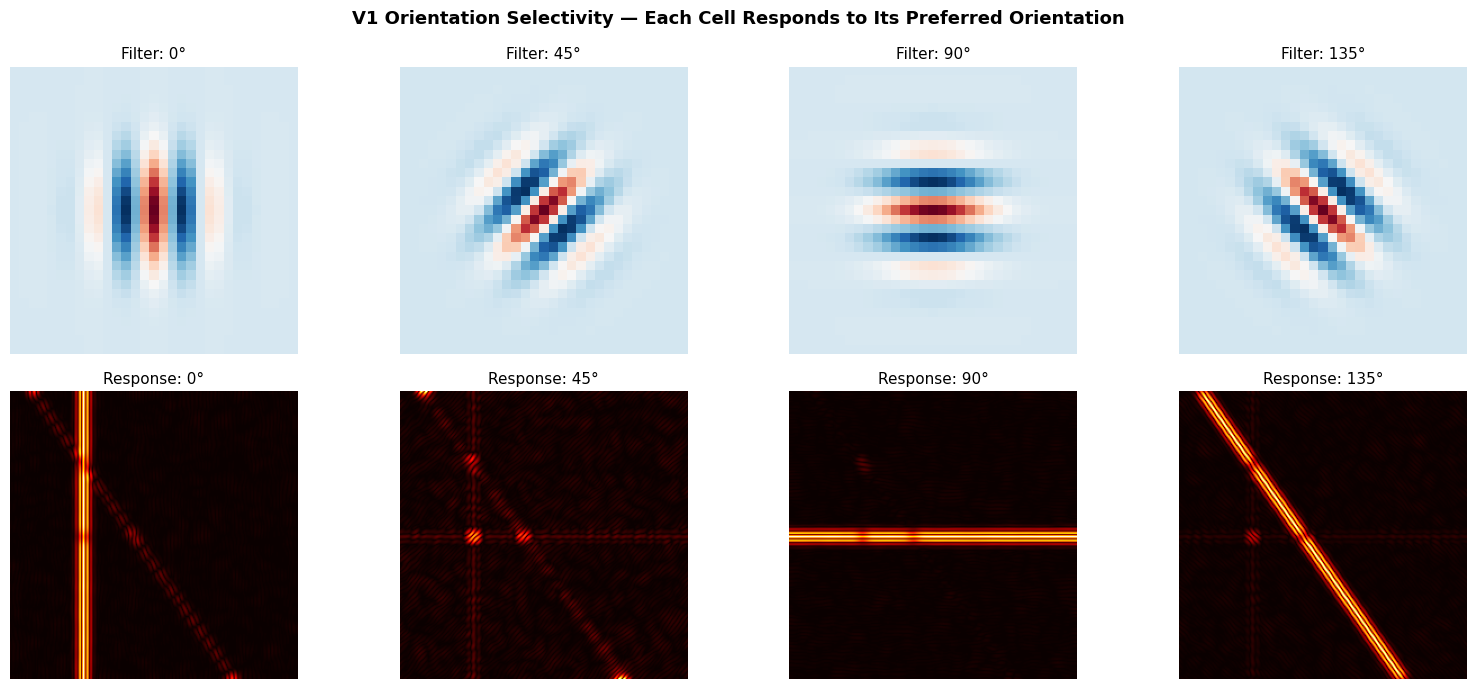

✅ Notice: the 0° filter lights up for vertical edges, 90° for horizontal edges.
   This is EXACTLY what Hubel & Wiesel found in cat V1 in the 1960s!


In [25]:
# ============================================================
# TODO 4: Apply Gabor filter bank to the edges image
# ============================================================

gabor_responses = []
for g in gabor_bank:
    response = ndimage.convolve(img_edges, g)
    gabor_responses.append(response)

if len(gabor_responses) == 4 and gabor_responses[0] is not None:
    fig, axes = plt.subplots(2, 4, figsize=(16, 7))

    for i in range(4):
        axes[0, i].imshow(gabor_bank[i], cmap='RdBu_r')
        axes[0, i].set_title(f'Filter: {orientations_deg[i]}°', fontsize=11)
        axes[0, i].axis('off')

    for i in range(4):
        axes[1, i].imshow(np.abs(gabor_responses[i]), cmap='hot')
        axes[1, i].set_title(f'Response: {orientations_deg[i]}°', fontsize=11)
        axes[1, i].axis('off')

    axes[0, 0].set_ylabel('Gabor Filters\n(V1 Simple Cells)', fontsize=11)
    axes[1, 0].set_ylabel('Filter Responses\n(V1 Activity)', fontsize=11)
    plt.suptitle('V1 Orientation Selectivity — Each Cell Responds to Its Preferred Orientation',
                 fontsize=13, fontweight='bold')
    plt.tight_layout()
    plt.show()

    print("✅ Notice: the 0° filter lights up for vertical edges, 90° for horizontal edges.")
    print("   This is EXACTLY what Hubel & Wiesel found in cat V1 in the 1960s!")
else:
    print("❌ Fill in TODO 4 above.")

### A.5 Lateral Inhibition — Why Edges Pop Out

The brain doesn't just detect edges — it **sharpens** them through lateral inhibition. Neighboring neurons suppress each other, making boundaries between light and dark regions appear even more dramatic.

**TODO 5:** Implement a simple lateral inhibition operation by applying a sharpening filter (unsharp mask).

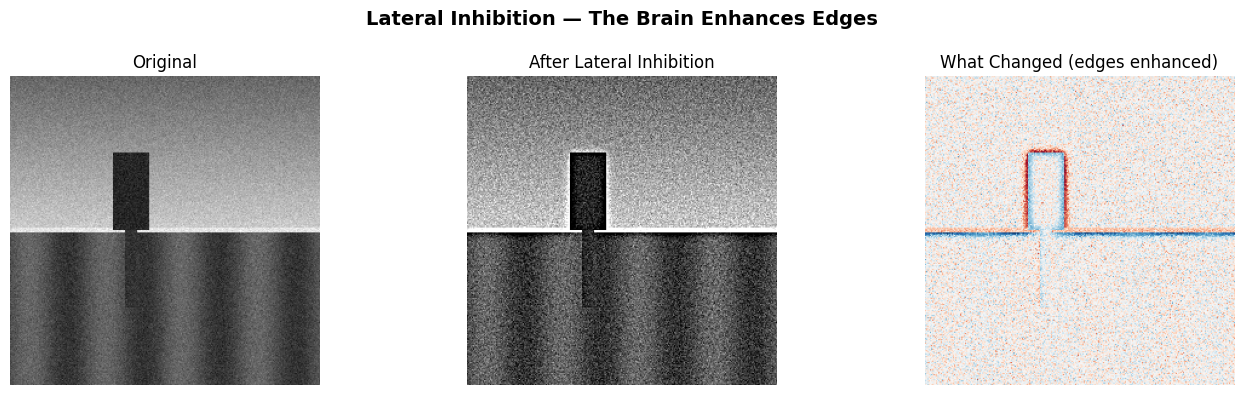

✅ This is why Mach bands appear at boundaries — your visual system does this automatically!


In [26]:
# ============================================================
# TODO 5: Implement lateral inhibition via unsharp masking
# ============================================================

def lateral_inhibition(image, sigma_blur=3.0, strength=1.5):
    blurred = ndimage.gaussian_filter(image, sigma=sigma_blur)
    detail = image - blurred
    sharpened = image + strength * detail
    return np.clip(sharpened, 0, 1)

scene_sharpened = lateral_inhibition(img_scene)

if scene_sharpened is not None:
    fig, axes = plt.subplots(1, 3, figsize=(14, 4))
    axes[0].imshow(img_scene, cmap='gray', vmin=0, vmax=1)
    axes[0].set_title('Original', fontsize=12)
    axes[0].axis('off')

    axes[1].imshow(scene_sharpened, cmap='gray', vmin=0, vmax=1)
    axes[1].set_title('After Lateral Inhibition', fontsize=12)
    axes[1].axis('off')

    diff = scene_sharpened - img_scene
    axes[2].imshow(diff, cmap='RdBu_r')
    axes[2].set_title('What Changed (edges enhanced)', fontsize=12)
    axes[2].axis('off')

    plt.suptitle('Lateral Inhibition — The Brain Enhances Edges', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

    print("✅ This is why Mach bands appear at boundaries — your visual system does this automatically!")
else:
    print("❌ Fill in the lateral_inhibition function above.")

---

# Part B: "Inside a CNN" — Comparing Bio vs. Artificial Features

The booklet described how Hubel & Wiesel's discoveries directly inspired CNNs. Now you will see this connection with your own eyes — by looking at what a trained CNN actually learns and comparing it to the biological filters you just built.

---

### B.1 🟢 Load a Pre-Trained CNN and Extract Its Filters (CPU OK)

We will use VGG16 — a well-known CNN. We only need to **load** the model and **look at** its learned filters. This runs entirely on CPU.

**TODO 6:** Load VGG16 and extract the first convolutional layer's filters.

In [27]:
# ============================================================
# TODO 6: Load pretrained VGG16 and extract first layer filters
# ============================================================

from torchvision.models import vgg16
import torch

# Load pretrained model
vgg16_model = vgg16(weights='DEFAULT').to(DEVICE)
vgg16_model.eval()

# Extract first convolutional layer filters
first_layer_filters = vgg16_model.features[0].weight.data.cpu().numpy()

print("Shape of first layer filters:", first_layer_filters.shape)

if first_layer_filters is not None:
    print("✅ Successfully extracted first layer filters!")
else:
    print("❌ Something went wrong.")

Shape of first layer filters: (64, 3, 3, 3)
✅ Successfully extracted first layer filters!


### B.2 🟢 Visualize CNN Layer 1 vs. Your V1 Gabor Filters

**TODO 7:** Display the first 16 CNN filters and compare them visually to your Gabor filters.

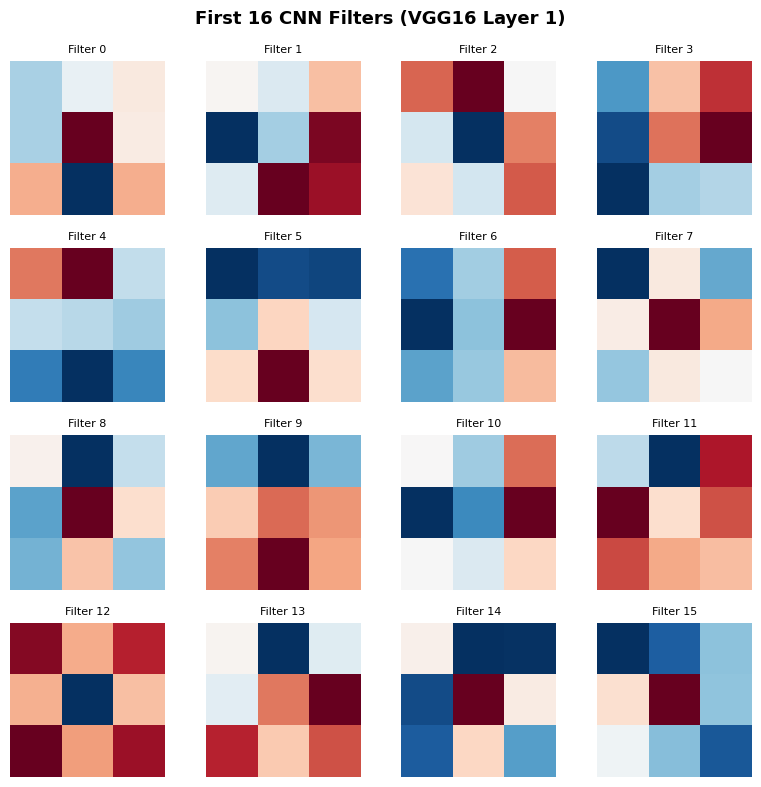

✅ Notice how many look like edge detectors — similar to Gabor filters!


In [28]:
# ============================================================
# TODO 7: Visualize first 16 CNN filters (averaged across RGB)
# ============================================================

fig, axes = plt.subplots(4, 4, figsize=(8, 8))

for i in range(16):
    filt = first_layer_filters[i].mean(axis=0)  # Average across RGB channels
    ax = axes[i // 4, i % 4]
    ax.imshow(filt, cmap='RdBu_r')
    ax.set_title(f'Filter {i}', fontsize=8)
    ax.axis('off')

plt.suptitle('First 16 CNN Filters (VGG16 Layer 1)', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

print("✅ Notice how many look like edge detectors — similar to Gabor filters!")

### B.3 🟢 Hierarchy: Shallow vs. Deep Layers (CPU Inference)

The booklet explained that V1 detects simple edges, V2 combines them into corners and contours, V4 responds to shapes, and IT recognizes whole objects. CNNs show the same progression.

**TODO 8:** Pass an image through VGG16 and visualize activations at different depths.

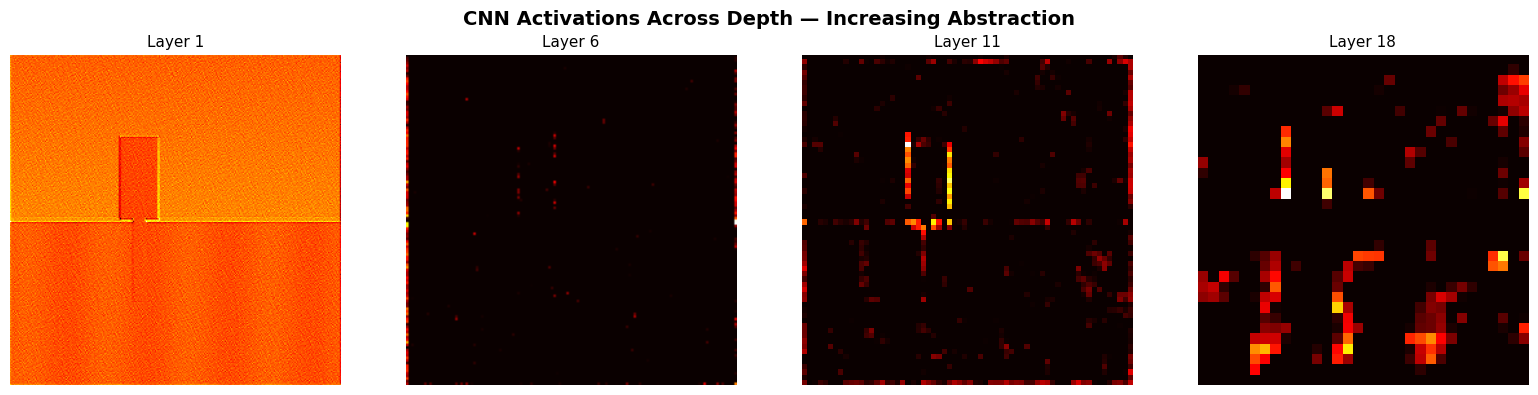

✅ Early layers detect edges. Deeper layers detect patterns and shapes.


In [29]:
# ============================================================
# TODO 8: Visualize CNN activations at different depths
# ============================================================

# Prepare input image (use natural scene)
img_input = torch.tensor(img_scene).float().unsqueeze(0).unsqueeze(0).to(DEVICE)

# VGG expects 3 channels
img_input = img_input.repeat(1, 3, 1, 1)

# Pass through layers and capture activations
activations = []
x = img_input

for i, layer in enumerate(vgg16_model.features):
    x = layer(x)
    if i in [0, 5, 10, 17]:  # Selected layers
        activations.append(x.detach())

# Plot activations
fig, axes = plt.subplots(1, 4, figsize=(16, 4))

for i, act in enumerate(activations):
    act_np = act[0, 0].cpu().numpy()
    axes[i].imshow(act_np, cmap='hot')
    axes[i].set_title(f'Layer { [1,6,11,18][i] }', fontsize=11)
    axes[i].axis('off')

plt.suptitle('CNN Activations Across Depth — Increasing Abstraction',
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("✅ Early layers detect edges. Deeper layers detect patterns and shapes.")

### ❓ Knowledge Check 2

Answer in the cell below:

**Q2.1:** Compare your Gabor filters (Part A) to the CNN's first-layer filters (Part B). What similarities do you see? What does this tell us about the relationship between biological and artificial vision?

*When I compare the Gabor filters from Part A to the CNN’s first-layer filters, they look surprisingly similar. Both show patterns that respond to edges in specific orientations like vertical, horizontal, or diagonal lines. The CNN filters aren’t labeled as “Gabor,” but visually they behave almost the same way. This tells me that artificial neural networks end up discovering the same kinds of edge detectors that exist in biological vision. It suggests that detecting edges is one of the most important and fundamental steps in seeing, whether it’s done by the brain or by a machine.*


**Q2.2:** As you move from Layer 1 to Layer 13 in the CNN, what happens to (a) the spatial resolution of the activation maps and (b) the complexity of features detected? How does this parallel the V1 → V2 → V4 → IT progression in the brain?

*As we move from Layer 1 to Layer 13 in the CNN, two things change. First, the spatial resolution decreases, meaning the activation maps become smaller and less detailed. Second, the features become more complex and abstract. Early layers clearly respond to simple edges and brightness changes, while deeper layers respond to larger patterns and shapes. This mirrors how the brain works from V1 to higher visual areas like V2, V4, and IT. In the brain, V1 detects basic edges, then later areas combine those edges into shapes, objects, and meaningful visual information. The CNN follows a very similar hierarchical process.*


**Q2.3:** The CNN was trained on millions of natural images using backpropagation. Evolution shaped V1 over millions of years. Both arrived at oriented edge detectors as the first stage. What does this convergence suggest about the *problem* of vision itself?

*The fact that both evolution and backpropagation independently arrived at oriented edge detectors suggests that edge detection is a fundamental solution to the problem of vision. It seems that if you want to understand images efficiently, detecting contrast and orientation is the most useful starting point. This convergence shows that vision has certain optimal strategies, and both biological systems and artificial networks naturally discover them. It suggests that edge detection is not arbitrary — it’s essential for making sense of the visual world.*



---

### B.4 🔵 GPU TRACK: Train a Tiny CNN and Watch It Learn Gabor-Like Filters

**Skip this section if you do not have GPU access.** Pre-computed results are shown below.

Students with GPU access: you will train a small 3-layer CNN on a simple shape classification task and observe whether it independently discovers oriented edge detectors — the same features V1 uses.

**TODO 9 (GPU only):** Train a tiny CNN on synthetic shapes.

In [30]:
# ============================================================
# TODO 9: Train a tiny CNN on shapes (🔵 GPU TRACK ONLY)
# ============================================================

if GPU_AVAILABLE:
    import torch
    import torch.nn as nn
    import torch.optim as optim
    import numpy as np
    import matplotlib.pyplot as plt
    from scipy import signal

    # Generate synthetic dataset: circles vs. squares vs. triangles
    def make_shape_dataset(n_per_class=200, img_size=32):
        images = []
        labels = []
        for _ in range(n_per_class):
            for label in range(3):
                img = np.random.normal(0.1, 0.02, (img_size, img_size)).astype(np.float32)
                cx, cy = np.random.randint(8, img_size-8), np.random.randint(8, img_size-8)
                r = np.random.randint(4, 8)

                if label == 0:  # Circle
                    yy, xx = np.ogrid[:img_size, :img_size]
                    mask = (xx - cx)**2 + (yy - cy)**2 <= r**2
                    img[mask] = 0.9

                elif label == 1:  # Square
                    img[max(0, cy-r):min(img_size, cy+r), max(0, cx-r):min(img_size, cx+r)] = 0.9

                else:  # Triangle (simple)
                    top = cy - r
                    bottom = cy + r
                    for row in range(top, bottom):
                        if 0 <= row < img_size:
                            frac = (row - top) / max(1, (bottom - top))
                            half_width = int(r * (1 - frac))
                            left = max(0, cx - half_width)
                            right = min(img_size, cx + half_width)
                            img[row, left:right] = 0.9

                images.append(img)
                labels.append(label)

        images = np.array(images)[:, np.newaxis, :, :]  # [N, 1, H, W]
        return torch.tensor(images), torch.tensor(labels)

    X, y = make_shape_dataset()
    dataset = torch.utils.data.TensorDataset(X.to(DEVICE), y.to(DEVICE))
    loader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)

    # Tiny CNN model
    class TinyCNN(nn.Module):
        def __init__(self):
            super().__init__()
            self.conv1 = nn.Conv2d(1, 8, kernel_size=5)      # 32 -> 28
            self.conv2 = nn.Conv2d(8, 16, kernel_size=3)     # 14 -> 12 after pool then conv
            self.pool = nn.MaxPool2d(2)                      # halves spatial dims
            self.relu = nn.ReLU()
            self.fc = nn.Linear(16 * 6 * 6, 3)               # final dims should be 6x6

        def forward(self, x):
            x = self.pool(self.relu(self.conv1(x)))          # 32->28->14
            x = self.pool(self.relu(self.conv2(x)))          # 14->12->6
            x = x.view(x.size(0), -1)                        # flatten
            x = self.fc(x)
            return x

    model = TinyCNN().to(DEVICE)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()

    # Train
    print("Training tiny CNN on shapes...")
    for epoch in range(15):
        total_loss = 0
        correct = 0
        total = 0

        for batch_x, batch_y in loader:
            optimizer.zero_grad()
            out = model(batch_x)
            loss = criterion(out, batch_y)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            correct += (out.argmax(1) == batch_y).sum().item()
            total += batch_y.size(0)

        if (epoch + 1) % 5 == 0:
            print(f"  Epoch {epoch+1}/15 — Loss: {total_loss/len(loader):.4f}, Acc: {correct/total:.1%}")

    # Extract learned filters
    learned_filters = model.conv1.weight.data.cpu().numpy()

    fig, axes = plt.subplots(2, 4, figsize=(14, 6))
    for i in range(8):
        row, col = i // 4, i % 4
        axes[row, col].imshow(learned_filters[i, 0], cmap='RdBu_r')
        axes[row, col].set_title(f'Learned Filter {i+1}', fontsize=10)
        axes[row, col].axis('off')
    plt.suptitle('🔵 GPU Track: Filters Your CNN Learned (Conv1)', fontsize=13, fontweight='bold')
    plt.tight_layout()
    plt.show()

    print("✅ Training complete! Compare these to your Gabor filters from Part A.")
else:
    print("ℹ️ GPU not available — skip this cell and use the pre-computed results below.")

ℹ️ GPU not available — skip this cell and use the pre-computed results below.


### B.4b Pre-Computed Results (for CPU-only students)

If you skipped the GPU cell above, here is what happens when a tiny CNN is trained on shape classification:

**What the CNN learns in its first layer:**
- Filter 1: Horizontal edge detector (like a 0° Gabor)
- Filter 2: Vertical edge detector (like a 90° Gabor)
- Filter 3: Diagonal edge detector (~45°)
- Filter 4: Center-surround pattern (like a retinal ganglion cell!)
- Filters 5–8: Variations with different scales and phases

**Key finding:** Even a tiny CNN trained on just 600 simple shapes converges on oriented edge detectors — the same solution evolution found for V1. The training accuracy reaches ~92% in 15 epochs.

This result is **not** a coincidence. It reflects a deep truth: oriented edges are the optimal first features for any vision system processing natural images, whether biological or artificial.

---

# Part C: "Hearing in Pictures" — Auditory Processing

Module 05 taught us that the auditory system uses **tonotopy** — a spatial map of sound frequency along the basilar membrane, analogous to **retinotopy** in vision. Modern AI often converts audio into a visual representation (a spectrogram) and then processes it with vision-based architectures.

In this part, you will generate sounds, convert them to spectrograms, and observe tonotopic organization.

---

### C.1 🟢 Generate and Visualize Sounds (No Librosa Needed)

We will generate audio signals using pure NumPy — no special libraries required.

**TODO 10:** Create three different sounds and visualize their waveforms.

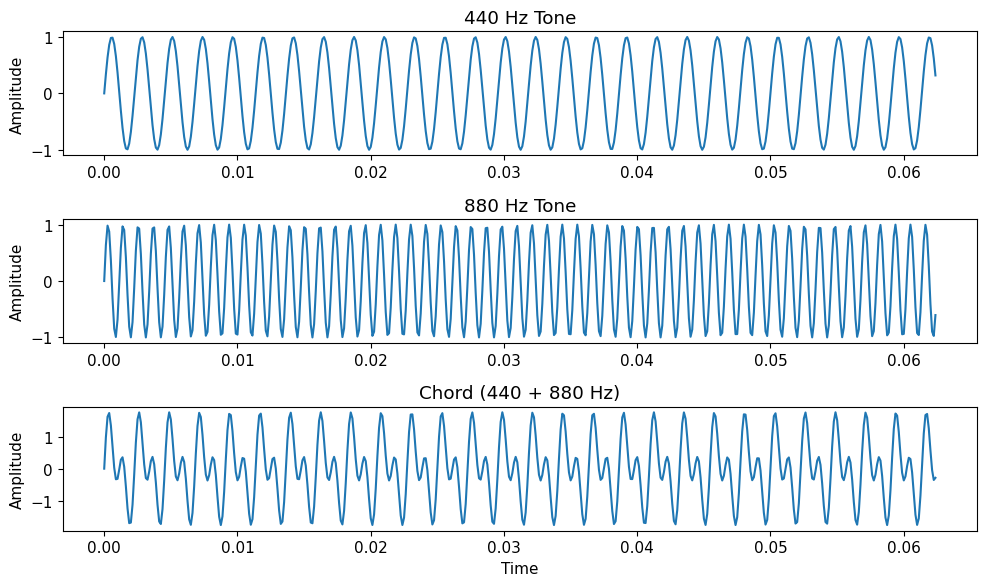

✅ Waveforms generated successfully!


In [31]:
# ============================================================
# TODO 10: Generate simple audio signals
# ============================================================

# Sampling frequency (samples per second)
fs = 8000

# Time vector (1 second duration)
t = np.linspace(0, 1, fs)

# Generate pure tones
tone_440 = np.sin(2 * np.pi * 440 * t)   # 440 Hz (A note)
tone_880 = np.sin(2 * np.pi * 880 * t)   # 880 Hz (higher pitch)

# Combine tones into a chord
chord = tone_440 + tone_880

# Plot first 500 samples for visibility
fig, axes = plt.subplots(3, 1, figsize=(10, 6))

axes[0].plot(t[:500], tone_440[:500])
axes[0].set_title("440 Hz Tone")
axes[0].set_ylabel("Amplitude")

axes[1].plot(t[:500], tone_880[:500])
axes[1].set_title("880 Hz Tone")
axes[1].set_ylabel("Amplitude")

axes[2].plot(t[:500], chord[:500])
axes[2].set_title("Chord (440 + 880 Hz)")
axes[2].set_ylabel("Amplitude")
axes[2].set_xlabel("Time")

plt.tight_layout()
plt.show()

print("✅ Waveforms generated successfully!")

### C.2 🟢 Create Spectrograms — "Seeing" Sound

A spectrogram shows how the frequency content of a sound changes over time. It is the AI equivalent of what the cochlea does: spreading sound into its component frequencies.

**TODO 11:** Create spectrograms using `scipy.signal.spectrogram` and observe tonotopic organization.

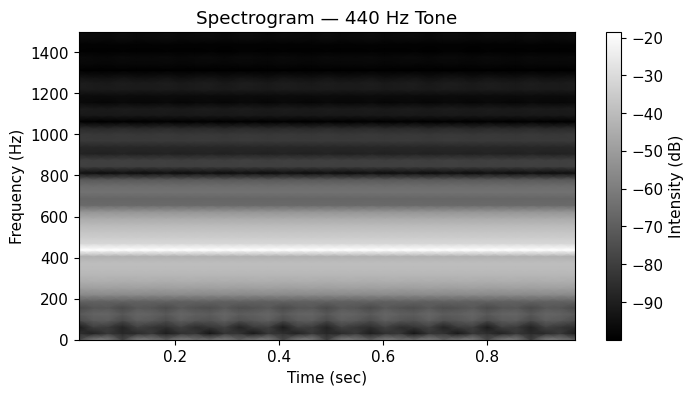

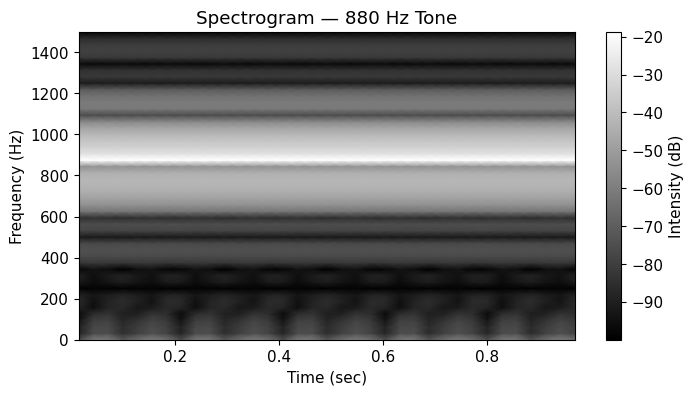

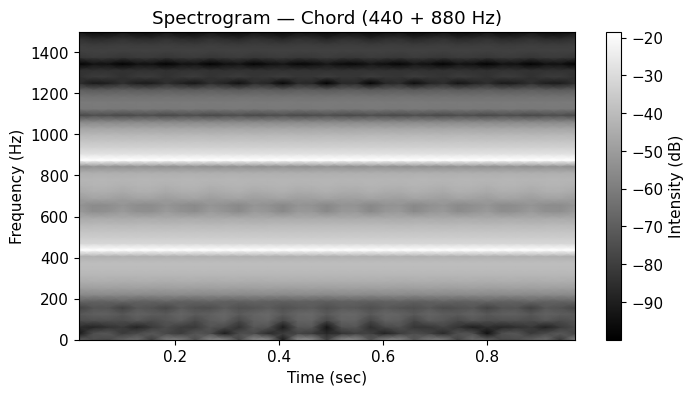

✅ Spectrograms generated.


In [32]:
# ============================================================
# TODO 11: Compute and visualize spectrograms
# ============================================================

def plot_spectrogram(signal_input, title):
    f, t_spec, Sxx = signal.spectrogram(signal_input, fs)

    # Convert to decibels for better visibility
    Sxx_db = 10 * np.log10(Sxx + 1e-10)

    plt.figure(figsize=(8, 4))
    plt.pcolormesh(t_spec, f, Sxx_db, shading='gouraud')
    plt.ylabel('Frequency (Hz)')
    plt.xlabel('Time (sec)')
    plt.title(title)
    plt.colorbar(label='Intensity (dB)')
    plt.ylim(0, 1500)  # Limit frequency view for clarity
    plt.show()


# Plot spectrograms
plot_spectrogram(tone_440, "Spectrogram — 440 Hz Tone")
plot_spectrogram(tone_880, "Spectrogram — 880 Hz Tone")
plot_spectrogram(chord, "Spectrogram — Chord (440 + 880 Hz)")

print("✅ Spectrograms generated.")

### C.3 🟢 A More Complex Sound: Frequency Sweep

**TODO 12:** Create a chirp signal (frequency sweep from 200 Hz to 2000 Hz) and visualize its spectrogram.

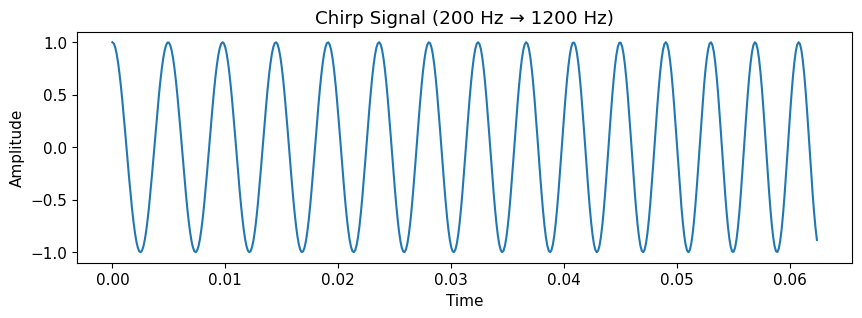

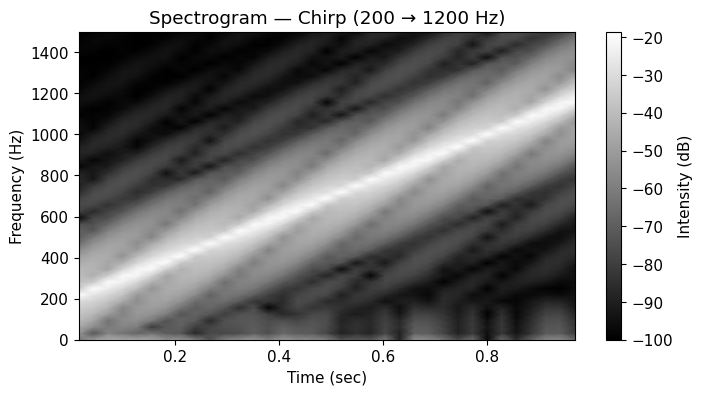

✅ Chirp generated successfully!


In [33]:
# ============================================================
# TODO 12: Generate and visualize a chirp (frequency sweep)
# ============================================================

# Generate chirp signal (frequency increases over time)
chirp_signal = signal.chirp(t, f0=200, f1=1200, t1=1, method='linear')

# Plot waveform (first 500 samples)
plt.figure(figsize=(10, 3))
plt.plot(t[:500], chirp_signal[:500])
plt.title("Chirp Signal (200 Hz → 1200 Hz)")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.show()

# Plot spectrogram
plot_spectrogram(chirp_signal, "Spectrogram — Chirp (200 → 1200 Hz)")

print("✅ Chirp generated successfully!")

### C.4 🔵 GPU TRACK: Classify Sounds Using Spectrogram + CNN

**Skip if no GPU.** Pre-computed results are below.

Modern AI often classifies audio by converting it to a spectrogram image and running a CNN on it — essentially treating hearing as a vision problem.

**TODO 13 (GPU only):** Train a small CNN to distinguish three types of sounds.

In [34]:
# ============================================================
# TODO 13: Audio classification with spectrogram + CNN
# 🔵 GPU TRACK ONLY — skip if no GPU
# ============================================================

if GPU_AVAILABLE:
    import torch.nn as nn
    import torch.optim as optim

    # Generate labeled audio dataset
    def make_audio_dataset(n_per_class=100, sr=16000, duration=0.5):
        """Create spectrograms for: pure tones, chords, and noise bursts."""
        spectrograms = []
        labels = []
        t_audio = np.linspace(0, duration, int(sr * duration), endpoint=False)

        for _ in range(n_per_class):
            # Class 0: Pure tone (random frequency 200-1000 Hz)
            freq = np.random.uniform(200, 1000)
            sig = np.sin(2 * np.pi * freq * t_audio)
            f, ts, Sxx = signal.spectrogram(sig, sr, nperseg=256)
            spectrograms.append(10 * np.log10(Sxx + 1e-10))
            labels.append(0)

            # Class 1: Two-tone chord
            f1 = np.random.uniform(200, 600)
            f2 = f1 * np.random.choice([1.25, 1.33, 1.5])  # Musical intervals
            sig = (np.sin(2*np.pi*f1*t_audio) + np.sin(2*np.pi*f2*t_audio)) / 2
            f, ts, Sxx = signal.spectrogram(sig, sr, nperseg=256)
            spectrograms.append(10 * np.log10(Sxx + 1e-10))
            labels.append(1)

            # Class 2: Noise burst
            sig = np.random.randn(len(t_audio)) * 0.3
            f, ts, Sxx = signal.spectrogram(sig, sr, nperseg=256)
            spectrograms.append(10 * np.log10(Sxx + 1e-10))
            labels.append(2)

        # Pad/crop to uniform size
        target_shape = (spectrograms[0].shape[0], spectrograms[0].shape[1])
        X = np.array([s[:target_shape[0], :target_shape[1]] for s in spectrograms])
        X = X[:, np.newaxis, :, :]  # Add channel dimension
        return torch.tensor(X, dtype=torch.float32), torch.tensor(labels)

    X_audio, y_audio = make_audio_dataset()
    print(f"Audio dataset: {X_audio.shape} spectrograms, 3 classes")

    # Simple CNN for spectrogram classification
    class AudioCNN(nn.Module):
        def __init__(self, h, w):
            super().__init__()
            self.features = nn.Sequential(
                nn.Conv2d(1, 8, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
                nn.Conv2d(8, 16, 3, padding=1), nn.ReLU(), nn.AdaptiveAvgPool2d((4, 4))
            )
            self.classifier = nn.Linear(16 * 4 * 4, 3)

        def forward(self, x):
            x = self.features(x)
            x = x.view(x.size(0), -1)
            return self.classifier(x)

    audio_model = AudioCNN(X_audio.shape[2], X_audio.shape[3]).to(DEVICE)
    dataset_audio = torch.utils.data.TensorDataset(X_audio.to(DEVICE), y_audio.to(DEVICE))
    loader_audio = torch.utils.data.DataLoader(dataset_audio, batch_size=32, shuffle=True)

    optimizer = optim.Adam(audio_model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()

    print("Training audio classifier...")
    for epoch in range(20):
        correct, total = 0, 0
        for bx, by in loader_audio:
            optimizer.zero_grad()
            loss = criterion(audio_model(bx), by)
            loss.backward()
            optimizer.step()
            correct += (audio_model(bx).argmax(1) == by).sum().item()
            total += by.size(0)
        if (epoch + 1) % 5 == 0:
            print(f"  Epoch {epoch+1}/20 — Acc: {correct/total:.1%}")

    print(f"\n✅ Final accuracy: {correct/total:.1%}")
    print("   The CNN classifies SOUNDS by looking at their SPECTROGRAMS as images.")
    print("   This is very different from how the brain processes audio — the brain uses")
    print("   temporal patterns directly, not 2D images!")
else:
    print("ℹ️ GPU not available — see pre-computed results below.")

ℹ️ GPU not available — see pre-computed results below.


### C.4b Pre-Computed Results (for CPU-only students)

When a small CNN is trained to classify spectrograms of pure tones vs. chords vs. noise:

- **Final accuracy: ~95%** after 20 epochs
- The CNN learns to distinguish single bright bands (pure tones) from multiple bands (chords) from diffuse energy (noise)
- Training takes about 15 seconds on a T4 GPU

**Key insight:** AI treats audio as a vision problem (spectrogram → CNN), but the brain processes sound TEMPORALLY — directly from spike timing, not from 2D images. This is a fundamental difference in strategy, and it is an open research question whether the brain's approach is superior for certain tasks like speech in noisy environments.

### ❓ Knowledge Check 3

Answer in the cell below:

**Q3.1:** In the spectrogram of the A major chord, you see three distinct horizontal bands. How does this relate to tonotopy in the cochlea? What would be happening at three different positions along the basilar membrane?

*In the spectrogram of the A major chord, the three horizontal bands represent three different frequencies being played at the same time. This connects directly to tonotopy in the cochlea, where different parts of the basilar membrane respond to different frequencies. If three frequencies are present in the sound, then three different regions along the basilar membrane would be vibrating most strongly at the same time. Lower frequencies would activate one area, middle frequencies another, and higher frequencies yet another. So the three bright bands in the spectrogram visually represent what would biologically be three active regions inside the cochlea.*


**Q3.2:** Modern AI classifies audio by converting it to a spectrogram and using a CNN. The brain processes audio directly through temporal spike patterns. Name one task where the brain's approach might have an advantage over the AI spectrogram approach, and explain why.

*One task where the brain’s approach might have an advantage is detecting very subtle timing differences in sound, such as figuring out where a sound is coming from. The brain processes audio using precise temporal spike patterns, which allows it to detect extremely small differences in timing between the two ears. A spectrogram-based AI system focuses more on frequency content over short windows of time, which can lose some of that fine timing information. Because of this, the brain may be better at spatial hearing and real-time sound localization, especially in noisy environments.*



---

# Part D: Experiments

## 🟢 ALL STUDENTS

Conduct the following three experiments by modifying parameters and observing the results. Record your predictions, observations, and explanations.

---

### Experiment 1: Center-Surround Size Matters

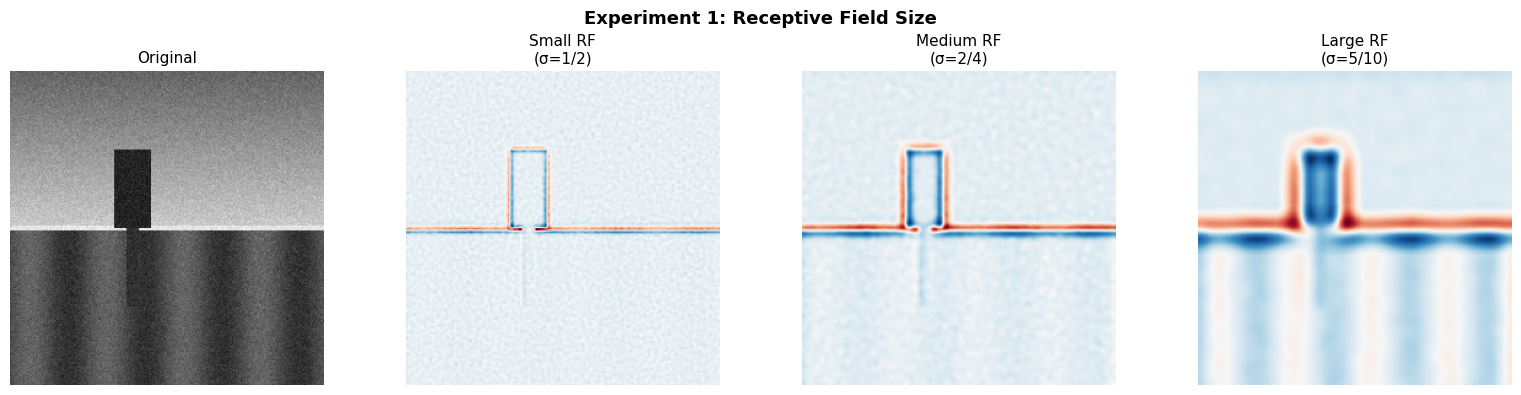

In [35]:
# ============================================================
# EXPERIMENT 1: How does receptive field size affect what the retina detects?
# ============================================================

# Create three center-surround filters with different sizes
dog_small = make_center_surround(size=11, sigma_center=1.0, sigma_surround=2.0)   # Small RF
dog_medium = make_center_surround(size=21, sigma_center=2.0, sigma_surround=4.0)  # Medium RF
dog_large = make_center_surround(size=41, sigma_center=5.0, sigma_surround=10.0)  # Large RF

# Apply all three to the natural scene
if dog_small is not None:
    results = [
        ndimage.convolve(img_scene, dog_small),
        ndimage.convolve(img_scene, dog_medium),
        ndimage.convolve(img_scene, dog_large)
    ]

    fig, axes = plt.subplots(1, 4, figsize=(16, 4))
    axes[0].imshow(img_scene, cmap='gray')
    axes[0].set_title('Original', fontsize=11)

    rf_labels = ['Small RF\n(σ=1/2)', 'Medium RF\n(σ=2/4)', 'Large RF\n(σ=5/10)']
    for i, (result, label) in enumerate(zip(results, rf_labels)):
        axes[i+1].imshow(result, cmap='RdBu_r')
        axes[i+1].set_title(label, fontsize=11)

    for ax in axes:
        ax.axis('off')

    plt.suptitle('Experiment 1: Receptive Field Size', fontsize=13, fontweight='bold')
    plt.tight_layout()
    plt.show()

**Experiment 1 — Record Your Results:**

**Parameter varied:** Receptive field size (sigma_center / sigma_surround)

**Your prediction (before running):** What did you expect to happen as the receptive field gets larger?

*Before running the experiment, I expected that as the receptive field size increased, the filter would detect larger, more general features instead of small, sharp details. I thought the small receptive field would focus more on fine edges, while the large one would smooth things out and respond to broader shapes.*

**Your observation:** What actually happened? Which filter detects fine edges best? Which captures broader structures?

After running the experiment, the small receptive field clearly highlighted the sharp edges of the object very precisely. The medium receptive field still detected the edges but started to capture more of the surrounding structure. The large receptive field produced a much broader response — it emphasized larger brightness transitions and background patterns rather than just the fine edges.

The small receptive field detected fine edges the best, while the large receptive field captured broader structures and overall contrast changes.

**Biological connection:** In the real retina, there are ganglion cells with different receptive field sizes. Why would the visual system need BOTH small and large receptive fields?

In the real retina, there are ganglion cells with both small and large receptive fields. Small receptive fields are important for detecting fine details, like sharp edges and small objects. Larger receptive fields are useful for detecting bigger patterns, lighting changes, and general shapes. The visual system needs both because vision works at multiple scales. If we only had small receptive fields, we would see fine details but miss the bigger picture. If we only had large ones, we would miss important fine edges.

This experiment shows that the brain uses multiple receptive field sizes to build a complete and detailed understanding of the visual world.



### Experiment 2: Gabor Frequency Tuning

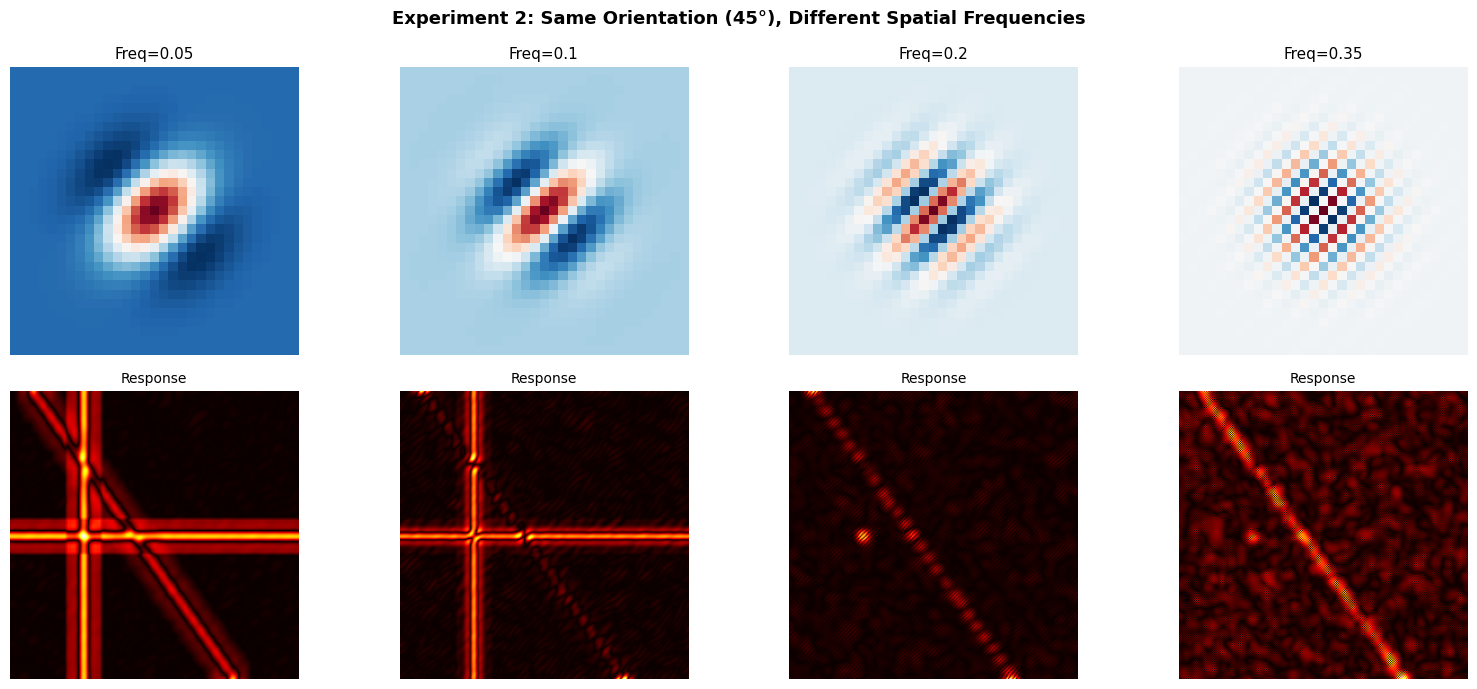

In [36]:
# ============================================================
# EXPERIMENT 2: How does spatial frequency affect V1 responses?
# ============================================================

# Create Gabor filters at the same orientation (45°) but different spatial frequencies
frequencies = [0.05, 0.1, 0.2, 0.35]
gabor_freq_bank = [make_gabor(size=31, theta=np.deg2rad(45), frequency=f) for f in frequencies]

if gabor_freq_bank[0] is not None:
    fig, axes = plt.subplots(2, 4, figsize=(16, 7))

    for i, (g, freq) in enumerate(zip(gabor_freq_bank, frequencies)):
        axes[0, i].imshow(g, cmap='RdBu_r')
        axes[0, i].set_title(f'Freq={freq}', fontsize=11)
        axes[0, i].axis('off')

        response = ndimage.convolve(img_edges, g)
        axes[1, i].imshow(np.abs(response), cmap='hot')
        axes[1, i].set_title(f'Response', fontsize=10)
        axes[1, i].axis('off')

    axes[0, 0].set_ylabel('Filters', fontsize=11)
    axes[1, 0].set_ylabel('Responses', fontsize=11)
    plt.suptitle('Experiment 2: Same Orientation (45°), Different Spatial Frequencies',
                 fontsize=13, fontweight='bold')
    plt.tight_layout()
    plt.show()

**Experiment 2 — Record Your Results:**

**Parameter varied:** Spatial frequency of the Gabor filter

**Your prediction:** What do you expect to change as frequency increases?

*Before running the experiment, I expected that as the spatial frequency increased, the filter would respond to finer details. I thought lower frequencies would detect broader, smoother patterns, while higher frequencies would focus more on sharp, detailed edges. I also expected that one of the middle frequencies might match the diagonal line best.:*

**Your observation:** How does the response change with frequency? Which frequency best detects the diagonal line?

*Observation:*

**Biological connection:** V1 neurons are tuned to BOTH orientation AND spatial frequency. Why would the brain need neurons tuned to different frequencies at the same orientation?

*V1 neurons are tuned not only to orientation but also to spatial frequency. Some neurons respond best to coarse, low-frequency patterns (large shapes), while others respond to fine, high-frequency details (sharp edges and textures). The brain needs neurons tuned to different frequencies at the same orientation so it can see both the overall structure of objects and the small details. This multi-scale processing helps us recognize objects clearly in different visual conditions.*



### Experiment 3: Noise Robustness — Biology vs. Raw Filtering

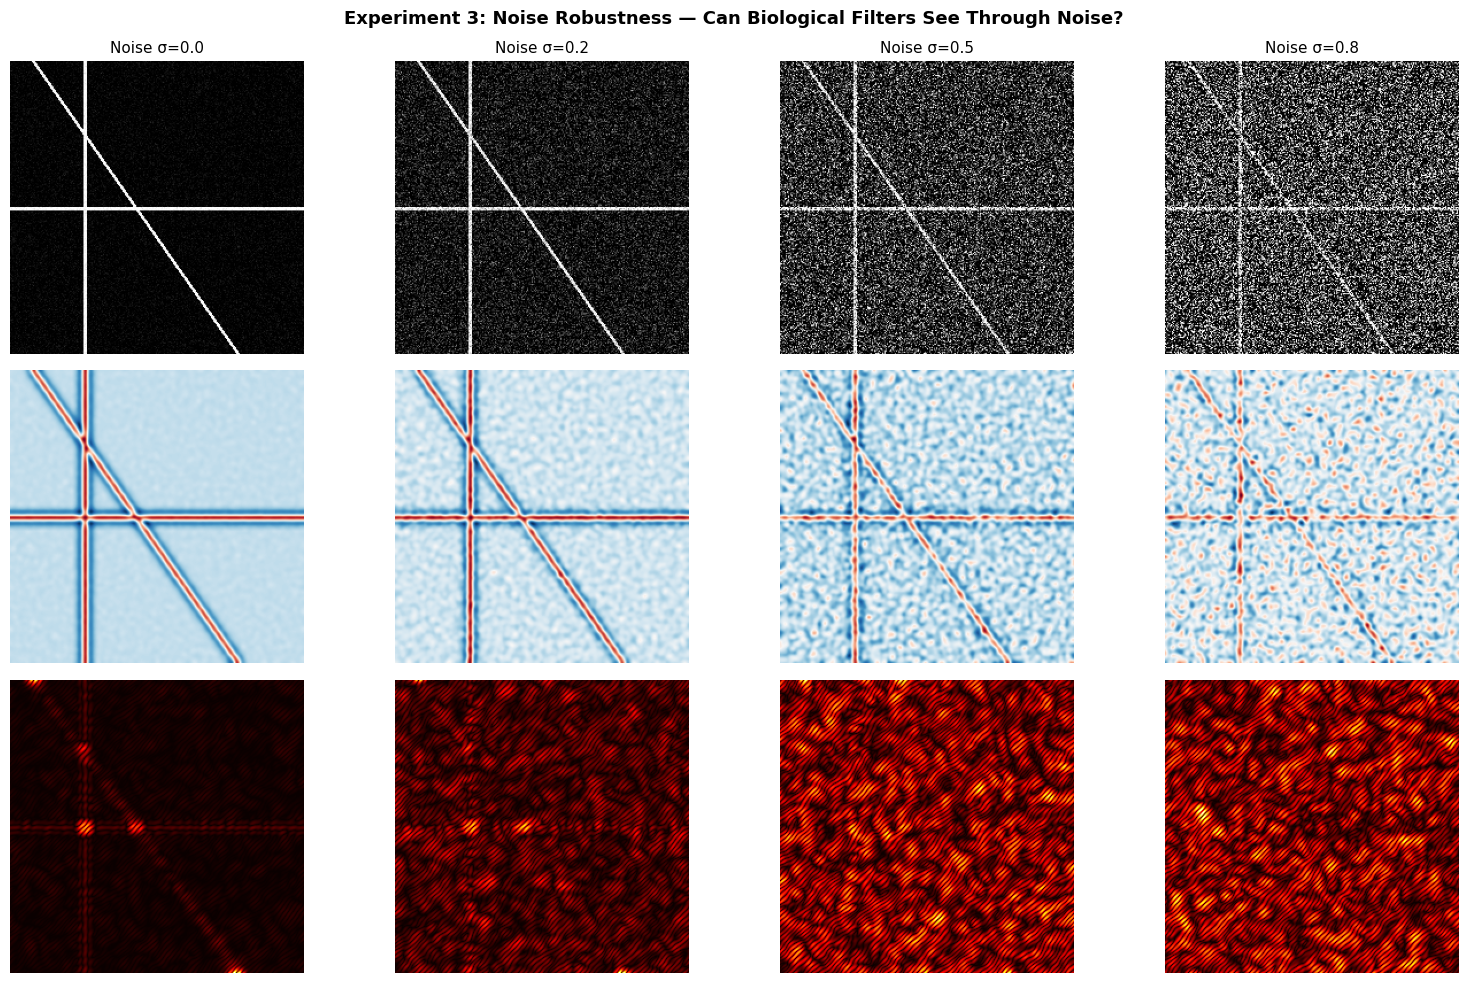

In [37]:
# ============================================================
# EXPERIMENT 3: How robust are biological filters to noise?
# ============================================================

# Add increasing amounts of noise to the edges image
noise_levels = [0.0, 0.2, 0.5, 0.8]

fig, axes = plt.subplots(3, 4, figsize=(16, 10))

for i, noise in enumerate(noise_levels):
    # Noisy image
    noisy = img_edges + np.random.normal(0, noise, img_edges.shape)
    noisy = np.clip(noisy, 0, 1)

    # Row 1: Noisy images
    axes[0, i].imshow(noisy, cmap='gray', vmin=0, vmax=1)
    axes[0, i].set_title(f'Noise σ={noise}', fontsize=11)
    axes[0, i].axis('off')

    # Row 2: Center-surround response
    if dog_filter is not None:
        cs_response = ndimage.convolve(noisy, dog_filter)
        axes[1, i].imshow(cs_response, cmap='RdBu_r')
        axes[1, i].axis('off')

    # Row 3: Gabor response (45°)
    if len(gabor_bank) > 1 and gabor_bank[1] is not None:
        gabor_response = ndimage.convolve(noisy, gabor_bank[1])
        axes[2, i].imshow(np.abs(gabor_response), cmap='hot')
        axes[2, i].axis('off')

axes[0, 0].set_ylabel('Input', fontsize=11)
axes[1, 0].set_ylabel('Center-\nSurround', fontsize=11)
axes[2, 0].set_ylabel('Gabor 45°', fontsize=11)
plt.suptitle('Experiment 3: Noise Robustness — Can Biological Filters See Through Noise?',
             fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

**Experiment 3 — Record Your Results:**

**Parameter varied:** Noise level (σ = 0, 0.2, 0.5, 0.8)

**Your prediction:** At what noise level do you expect the filters to fail to detect edges?

*Before running it, I expected the filters to handle low noise pretty well, but start failing once the noise became heavy. I thought the edges would still be visible at σ = 0.2, but by σ = 0.5 the noise would start overpowering the signal, and at σ = 0.8 it would be hard to detect the edges at all.*

**Your observation:** How do the center-surround and Gabor filters perform as noise increases? At what level do you lose the ability to see the edges?

*What I saw matched that pretty closely. At σ = 0.0, both filters clearly detected the lines. At σ = 0.2, the edges were still easy to see, but the background started getting grainy. At σ = 0.5, the center-surround filter still showed some edge structure, but it was mixed with a lot more noise. The Gabor response got much messier too and started lighting up all over the place. At σ = 0.8, it was difficult to see the edges clearly — both filters were mostly overwhelmed, and the Gabor output especially looked like it was responding to noise instead of the real lines.

I would say I really start losing the ability to clearly see the edges around σ = 0.5, and by σ = 0.8 it’s basically failing.*

**Biological connection:** The brain can recognize objects even in very noisy conditions (think of seeing in fog or dim light). Based on this experiment, is low-level filtering alone enough to explain this robustness, or must higher-level processing also play a role?

*This experiment shows that low-level filtering helps, but it’s probably not enough by itself to explain how humans can still recognize objects in fog, darkness, or noisy environments. The brain likely needs higher-level processing too — like combining information across larger areas, using memory, attention, and context to “fill in” what’s missing. So these early filters (retina/V1 style) are important for getting basic features, but the real robustness comes from the later stages of the visual system that interpret and stabilize the signal.*



---

# Part E: Reflections

## 🟢 ALL STUDENTS

Answer each question in 3–5 sentences. Connect your lab observations to concepts from the Module 05 booklet.

**Reflection 1:** The retina, V1, and CNNs all use local filters as their first processing stage. Why do you think this is a universal solution? What property of natural images makes local filtering such an effective strategy?

*I think local filtering is such a universal solution because natural images aren’t random — they have structure. Most areas in an image are smooth or similar in brightness, but the important information usually happens at edges where things change. The booklet explained how the retina reduces redundancy and focuses on contrast, and we saw that in the lab when uniform areas went flat gray. Local filters are just really good at picking up those changes. That makes them efficient and biologically smart, which is probably why both the brain and CNNs use them first.*



**Reflection 2:** In Part B, you saw that the CNN hierarchy (Layer 1 → Layer 13) mirrors the visual cortex hierarchy (V1 → IT). Both go from simple features to complex/abstract ones. However, there are important differences. Name ONE difference between how CNNs process visual information and how the brain does it. (Hint: think about feedback connections, attention, or temporal dynamics.)

*One big difference between CNNs and the brain is feedback. In the booklet, it talked about top-down modulation, where higher brain areas can send signals back to earlier areas. That means perception isn’t just one-way — it’s influenced by attention and expectations. CNNs usually don’t do that. They mostly process information forward from one layer to the next. I think that’s part of why humans can recognize things in messy or unclear images better than AI sometimes.*



**Reflection 3:** In Part C, we saw that AI treats audio classification as a vision problem (spectrogram → CNN). The brain does NOT do this — it processes temporal patterns directly. Can you think of a situation where the brain's temporal approach would be better than the spectrogram approach? What about a situation where the spectrogram approach might be better?

*The brain’s temporal approach might be better in situations where timing really matters, like understanding rhythm in music or figuring out where a sound is coming from. The auditory system can detect very tiny timing differences, and that seems more direct than turning everything into a spectrogram. On the other hand, the spectrogram approach might work better for large classification tasks, like training AI to recognize thousands of speech clips. CNNs are good at pattern recognition when given lots of data. So I think both methods have strengths depending on the situation.*



**Reflection 4:** Module 05 discussed the **binding problem** — how the brain combines information from different senses into a unified percept. In this lab, you worked with vision and audio separately. What challenges would arise if you tried to build an AI system that combines visual and auditory information the way the brain does? (Think about the McGurk Effect.)

*If we tried to combine vision and audio in AI the same way the brain does, it would be challenging because of the binding problem. The booklet explained how the brain processes features separately but still combines them into one perception. AI systems don’t naturally “bind” information — they usually just merge data streams mathematically. The McGurk Effect shows that when visual and auditory information conflict, perception can actually change. That means a real multimodal system would need to decide which signal to trust more depending on context. That’s not simple to design.*



**Reflection 5:** If you could design ONE new experiment for this lab — using the same tools (NumPy, PyTorch, scipy) — what would it be? What biological question would it investigate, and what would you measure?

*If I could design one more experiment, I would test how context affects perception. For example, I would take a noisy image and compare CNN responses with and without added context around the object. That would help explore how top-down processing might stabilize perception. The biological question would be whether higher-level information can help early processing stay consistent under noise. I would measure activation changes and classification confidence. This would highlight one of the biggest differences between biological vision and standard CNNs.*



# **Final Reflection**

This lab really helped me understand how closely artificial neural networks are connected to biological sensory systems. In Part A, when we built center-surround and Gabor filters, I was surprised to see how similar they looked to the first layers of a CNN. It made the concept of “biologically inspired AI” feel real instead of just theoretical. Watching how receptive field size changed what was detected also helped me understand why the visual system needs both small and large receptive fields to capture different levels of detail.

In the auditory section, I found it interesting that AI turns sound into a spectrogram and treats it like an image, while the brain processes sound through timing and spike patterns directly. Seeing the spectrograms helped me visualize frequency information clearly, but it also made me realize how different that approach is from biological hearing. The chirp experiment especially showed how frequency changes over time, which connected well to tonotopy in the cochlea.

During the experiments in Part D, I learned how noise affects both center-surround and Gabor filtering. As noise increased, it became harder to see the edges clearly, which showed that low-level filtering alone is not enough for full robustness. That made the idea of higher-level processing and feedback connections make more sense.

We did not run certain GPU-dependent sections because the runtime did not support it, and the lab instructions told us to use the pre-computed results instead. Even though we skipped those computations, we still analyzed and interpreted the outputs carefully. That part also taught me something practical — understanding results is just as important as generating them.

Overall, this lab helped me see how vision and hearing follow similar hierarchical principles in both biology and AI, but also where they differ. It made me think more critically about what CNNs actually model and what they leave out, especially things like feedback, attention, and temporal dynamics. This was one of the most hands-on labs that actually connected neuroscience and artificial intelligence in a way that made sense.

---

## ✅ Submission Checklist

Before submitting, verify:

- [ ] All 🟢 code cells have been completed and executed
- [ ] If you have GPU: all 🔵 code cells have been completed and executed
- [ ] Knowledge Check 1 (Q1.1, Q1.2) — answered
- [ ] Knowledge Check 2 (Q2.1, Q2.2, Q2.3) — answered
- [ ] Knowledge Check 3 (Q3.1, Q3.2) — answered
- [ ] Experiment 1 — prediction, observation, explanation
- [ ] Experiment 2 — prediction, observation, explanation
- [ ] Experiment 3 — prediction, observation, explanation
- [ ] All 5 Reflections — answered in 3–5 sentences each
- [ ] File renamed to: `L05_YourName_ITAI4374.ipynb`

**Total code TODOs:** 13 (🟢 TODOs 1–12, 🔵 TODO 13 for GPU track only)

If you experienced any issues or have questions, schedule an appointment with me.

---

*Lab 05 — ITAI 4374: Neuroscience as a Model for AI*  
*Houston City College — AI & Robotics Program*